# Diagnostic Action Sequence Prediction (DAS) Model

This model uses past sequences of diagnostic actions to predict the most likely sequence of future actions. It does not consider the fault or claim history of a vehicle.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, pad_sequences
from keras.metrics import AUC, Precision, Recall
from keras.utils import to_categorical
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

MODEL_NAME = 'das'

In [47]:
# Load prepared data
df = pd.read_csv('./data_out/prepared_chunks_data.csv', low_memory=False)

In [48]:
# Encode target 'otxsequence' feature using LabelEncoder
label_encoder = LabelEncoder()
df.loc[:, 'otxsequence'] = label_encoder.fit_transform(df['otxsequence'])
all_classes = to_categorical(label_encoder.transform(label_encoder.classes_))
num_classes = all_classes.shape[1]

/var/folders/jr/q6r6st3d7577lv0703lr57mm0000gn/T/ipykernel_69548/990468071.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'otxsequence'] = label_encoder.fit_transform(df['otxsequence'])


In [49]:
# Sort values by 'consultationid' to ensure actions for the same consultation are together
df.sort_values(['consultationid', 'timestamp'], inplace=True)
df['otxsequence'] = df['otxsequence'].astype(str)

# Group by consultationid and join the activities
grouped = df.groupby('consultationid')['otxsequence'].agg(lambda x: list(set(x))).reset_index()
# Filter out all the groups with less than 2 actions
grouped = grouped[grouped['otxsequence'].apply(len) > 1]
grouped = grouped.drop_duplicates('consultationid')
sequences = grouped['otxsequence'].apply(lambda x: list(map(int, x)))

In [50]:
input_length = 1  # Single action will be used to predict the next seq_length actions
seq_length = 1 # Single action will be predicted

X, y = [], []
for seq in sequences:
    for i in range(0, len(seq)-1):
        X.append([seq[i]])
        y.append(seq[i+1])

# Pad sequences to ensure consistent length
X = pad_sequences(X, maxlen=input_length, padding='post')
y_onehot = to_categorical(y, num_classes=num_classes)

In [51]:
# Train-test split
train_input, test_input, train_out, test_out = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

2023-08-05 23:20:00.118864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 23:20:00.122612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 23:20:00.124895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

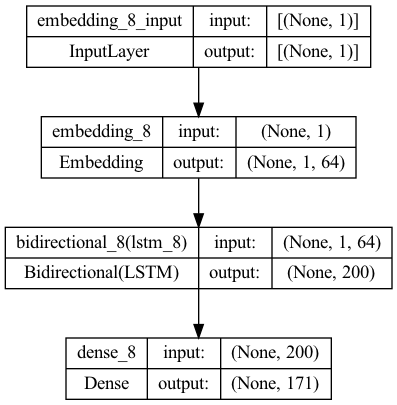

In [52]:
num_activities = df['otxsequence'].nunique()

model = Sequential()
model.add(Embedding(input_dim=num_activities+1, output_dim=64, input_length=input_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(num_activities, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',
                                                                          AUC(name='auc', multi_label=True),
                                                                          Precision(name='precision'),
                                                                          Recall(name='recall')])
plot_model(model, to_file=f'out/models/{MODEL_NAME}/{MODEL_NAME}_layers.png', show_shapes=True, show_layer_names=True)

In [53]:
early_stopping_monitor = EarlyStopping(
    monitor='accuracy',
    min_delta=0.001,  # minimum change to qualify as an improvement
    patience=10,  # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_input,
    train_out,
    epochs=50,
    batch_size=32,
    validation_data=(test_input, test_out),
    callbacks=[early_stopping_monitor])

Epoch 1/50


2023-08-05 23:20:02.226662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 23:20:02.228499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 23:20:02.230668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/44 [========================>.....] - ETA: 0s - loss: 5.0436 - accuracy: 0.2711 - auc: 0.2461 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-08-05 23:20:08.288432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 23:20:08.290612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 23:20:08.292561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - 7s 37ms/step - loss: 5.0035 - accuracy: 0.2711 - auc: 0.2525 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 4.6789 - val_accuracy: 0.2686 - val_auc: 0.1750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
44/44 [==============================] - 0s 8ms/step - loss: 3.7564 - accuracy: 0.2146 - auc: 0.2930 - precision: 0.9817 - recall: 0.0765 - val_loss: 2.9919 - val_accuracy: 0.1971 - val_auc: 0.2360 - val_precision: 0.9846 - val_recall: 0.1829
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 2.8060 - accuracy: 0.2761 - auc: 0.3616 - precision: 0.9773 - recall: 0.1845 - val_loss: 2.6605 - val_accuracy: 0.3371 - val_auc: 0.2481 - val_precision: 0.9846 - val_recall: 0.1829
Epoch 4/50
44/44 [==============================] - 0s 7ms/step - loss: 2.5250 - accuracy: 0.3455 - auc: 0.3796 - precision: 0.8962 - recall: 0.2039 - val_loss: 2.4469 - val_accuracy: 0.3800 - val_auc: 0.2519 - val_precision: 0.9846

11/11 [==============================] - 0s 5ms/step - loss: 2.1343 - accuracy: 0.5200 - auc: 0.2736 - precision: 0.7033 - recall: 0.4200


2023-08-05 23:20:31.049897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-05 23:20:31.051844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-05 23:20:31.053694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 2ms/step
Test Loss: 2.1343231201171875
Test Accuracy: 0.5199999809265137
Test AUC-ROC: 0.27360081672668457
Test Precision: 0.7033492922782898
Test Recall: 0.41999998688697815
Test F1: 0.525939169611354
Test NDCG: 0.7235781191930362


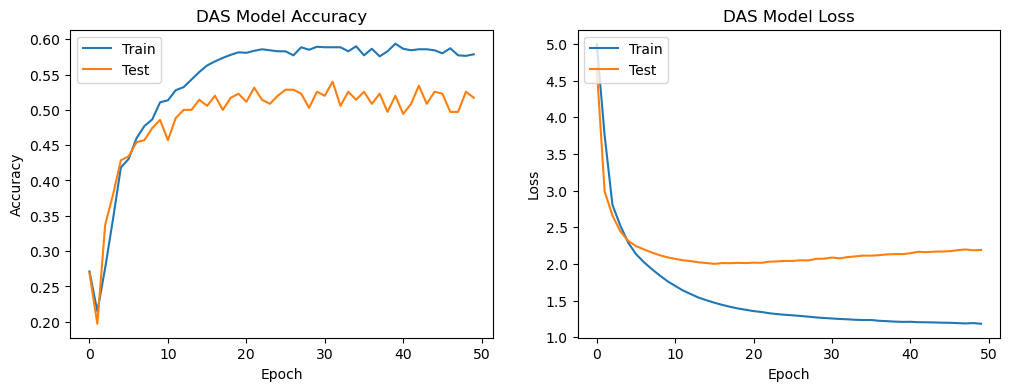

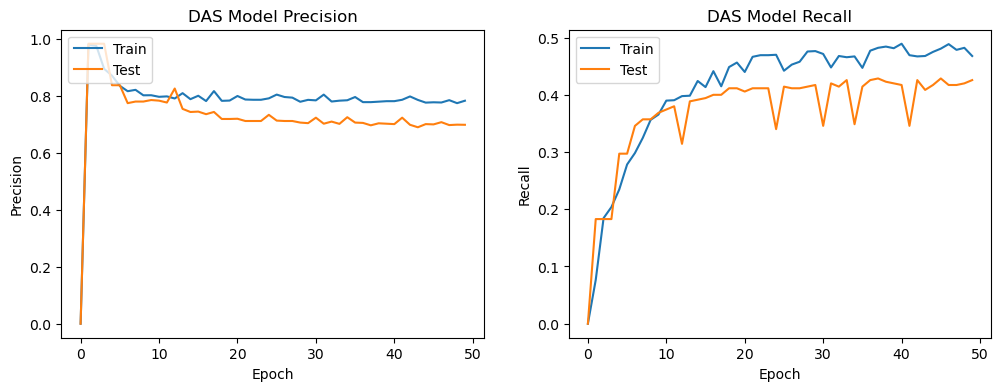

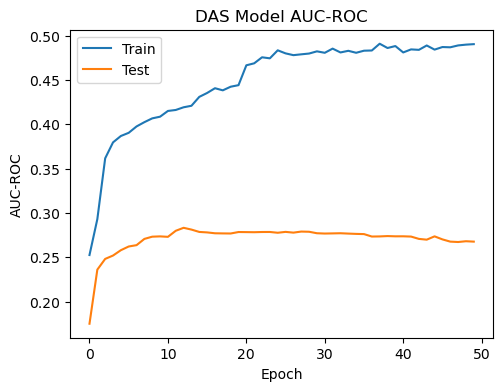

In [54]:
from sklearn.metrics import ndcg_score
from model_utils import save_plot_accuracy_loss, save_plot_precision_recall, save_plot_auc

# Evaluate the performance of the model on the test data
loss, accuracy, auc, precision, recall = model.evaluate(test_input, test_out)
f1 = 2 * (recall * precision / (recall + precision))
y_pred = model.predict(test_input)
ndcg = ndcg_score(test_out, y_pred)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test AUC-ROC: {auc}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1: {f1}")
print(f"Test NDCG: {ndcg}")

save_plot_accuracy_loss(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training')
save_plot_precision_recall(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training2')
save_plot_auc(history, 'DAS', f'{MODEL_NAME}/{MODEL_NAME}_training3')

plt.savefig(f'out/models/{MODEL_NAME}/{MODEL_NAME}_training.png')

In [55]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model.save(f'out/models/{MODEL_NAME}_{timestamp}.keras')